In [ ]:
!pip install rank_bm25
!pip install sentence_transformers
!git clone https://github.com/cr-nlp/project1-2023.git

import urllib.request as re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from collections import defaultdict
import nltk
import math
nltk.download('stopwords')
nltk.download('punkt')


def loadNFCorpus():
	dir = "./project1-2023/"
	filename = dir +"dev.docs"

	dicDoc={}
	with open(filename) as file:
		lines = file.readlines()
	for line in lines:
		tabLine = line.split('\t')
		#print(tabLine)
		key = tabLine[0]
		value = tabLine[1]
		#print(value)
		dicDoc[key] = value
	filename = dir + "dev.all.queries"
	dicReq={}
	with open(filename) as file:
		lines = file.readlines()

	for line in lines:
		tabLine = line.split('\t')
		key = tabLine[0]
		value = tabLine[1]
		dicReq[key] = value

	filename = dir + "dev.2-1-0.qrel"
	dicReqDoc=defaultdict(dict)
	with open(filename) as file:
		lines = file.readlines()
	for line in lines:
		tabLine = line.strip().split('\t')
		req = tabLine[0]
		doc = tabLine[2]
		score = int(tabLine[3])
		dicReqDoc[req][doc]=score
	return dicDoc, dicReq, dicReqDoc


Cloning into 'project1-2023'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 2.30 MiB | 4.86 MiB/s, done.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def text2TokenList(text):
	stopword = stopwords.words('english')
	#print("LEN DE STOPWORD=",len(stopword))
	word_tokens = word_tokenize(text.lower())
	word_tokens_without_stops = [word for word in word_tokens if word not in stopword and len(word)>2]
	return word_tokens_without_stops


In [ ]:
def docsandreqsToKeep(startDoc, endDoc):

    dicDoc, dicReq, dicReqDoc = loadNFCorpus()

    docsToKeep = []
    reqsToKeep = []
    dicReqDocToKeep = defaultdict(dict)

    i = startDoc
    for reqId in dicReqDoc:
        if i > (endDoc - startDoc):  # nbDocsToKeep:
            break
        for docId in dicReqDoc[reqId]:
            dicReqDocToKeep[reqId][docId] = dicReqDoc[reqId][docId]
            docsToKeep.append(docId)
            i = i + 1
        reqsToKeep.append(reqId)
    docsToKeep = list(set(docsToKeep))

    return docsToKeep, reqsToKeep, dicReqDocToKeep

In [ ]:
from rank_bm25 import BM25Okapi
def Tokenize_Embedding(docsToKeep, reqsToKeep,dicDoc,dicReq):

    #Cette fonction créer et retourne le corpus et les requêtes vectorisé à partir du modèle BERT ainsi que le corpus et les requete tokenisé

    embedder = SentenceTransformer('bert-base-nli-mean-tokens') #BERT BASE

    corpusDocTokenList = []
    embedded_corpus = []
    corpusReqTokenList = {}
    corpusDicoDocName={}
    i = 0
    for k in docsToKeep:

      corpusDocTokenList.append(text2TokenList(dicDoc[k]))
      embedded_corpus.append(embedder.encode(dicDoc[k]))
      corpusDicoDocName[k] = i
      i = i + 1

    #print("reqs...")
    corpusReqName=[]
    embedded_queries={}
    corpusDicoReqName={}
    i = 0
    for k in reqsToKeep:
      corpusReqTokenList[k] = text2TokenList(dicReq[k])
      embedded_queries[k] = embedder.encode(dicReq[k])
      corpusReqName.append(k)
      corpusDicoReqName[k] = i
      i = i + 1
    return corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,embedded_corpus,embedded_queries
    #print("bm25 doc indexing...")



In [ ]:
def init_vb(corpusDocTokenList):
        #initialisation des variables pour le calcul de bm25
        nd = {}  # word -> number of documents with word
        num_doc = 0
        doc_len=[]
        doc_freqs=[]
        corpus_size=0
        avgdl=0
        for document in corpusDocTokenList:
            doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word]+=1
                except KeyError:
                    nd[word] = 1

            corpus_size += 1

        avgdl = num_doc / corpus_size
        return num_doc,doc_len,doc_freqs,corpus_size,avgdl,nd

def calc_idf(nd,corpus_size,epsilon=0.25):
    """
    Calculates frequencies of terms in documents and in corpus.
    This algorithm sets a floor on the idf values to eps * average_idf
    """
    # collect idf sum to calculate an average idf for epsilon value
    idf_sum = 0
    dicidf={}
    # collect words with negative idf to set them a special epsilon value.
    # idf can be negative if word is contained in more than half of documents
    negative_idfs = []
    for word, freq in nd.items():
        idf = math.log(corpus_size - freq + 0.5) - math.log(freq + 0.5)
        dicidf[word] = idf
        idf_sum += idf
        if idf < 0:
           negative_idfs.append(word)
    average_idf = idf_sum / len(dicidf)
    eps = epsilon * average_idf
    for word in negative_idfs:
        dicidf[word] = eps
    return dicidf

def Get_score(corpusDocTokenList,query,k1=1.5,b=0.75):
  #Calcul de BM25
  num_doc,doc_len,doc_freqs,corpus_size,avgdl,nd = init_vb(corpusDocTokenList)

  score = np.zeros(len(corpusDocTokenList))
  dicidf = calc_idf(nd,corpus_size)
  doc_len = np.array(doc_len)


  for q in query:
      q_freq = np.array([(doc.get(q) or 0) for doc in doc_freqs])
      score += (dicidf.get(q) or 0) * (q_freq * (k1 + 1) /(q_freq + k1 * (1 - b + b * doc_len / avgdl)))
  return score

In [ ]:
  from sklearn.metrics import ndcg_score

  def Scoring(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,embedded_corpus,embedded_queries,alpha=0.5):

    #Fonction qui renvoie le ndcg avec l'association de BM25 et Bert

    #bm25 = BM25Okapi(corpusDocTokenList)
    #bm25 = Get_score(corpusDocTokenList)#,reqTokenList)

    ndcgCumul=0
    corpusReqVec={}
    ndcgBM25Cumul=0
    nbReq=0
    ndcgTop=5


    for req in corpusReqTokenList:

      reqTokenList = corpusReqTokenList[req]
      #doc_scores = bm25.get_scores(reqTokenList)
      doc_scores = Get_score(corpusDocTokenList,reqTokenList)
      doc_scores = (doc_scores-np.min(doc_scores))/(np.max(doc_scores)-np.min(doc_scores))

      emb_query = embedded_queries[req]

      bert_scores = Bert_score(embedded_corpus,emb_query)
      trueDocs = np.zeros(len(corpusDocTokenList))

      def_scores = alpha*doc_scores+(1-alpha)*bert_scores

      for docId in corpusDicoDocName:
        if req in dicReqDocToKeep:
          if docId in dicReqDocToKeep[req]:
            #get position docId
            posDocId = corpusDicoDocName[docId]
            trueDocs[posDocId] = dicReqDocToKeep[req][docId]
            #print("TOKEEP=",docId)
            #print(trueDocs)
      ndcgBM25Cumul = ndcgBM25Cumul + ndcg_score([trueDocs], [def_scores],k=ndcgTop)
      nbReq = nbReq + 1
    ndcgBM25Cumul = ndcgBM25Cumul / nbReq
    #print("ndcg bm25=",ndcgBM25Cumul)
    return ndcgBM25Cumul
def Scoring_W2V(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,w2v_corpus,w2v_queries,alpha=0.5):

    #Fonction qui renvoie le ndcg avec l'association de BM25 et Bert

    #bm25 = BM25Okapi(corpusDocTokenList)
    #bm25 = Get_score(corpusDocTokenList)#,reqTokenList)

    ndcgCumul=0
    corpusReqVec={}
    ndcgBM25Cumul=0
    nbReq=0
    ndcgTop=5


    for req in corpusReqTokenList:

      reqTokenList = corpusReqTokenList[req]
      #doc_scores = bm25.get_scores(reqTokenList)
      doc_scores = Get_score(corpusDocTokenList,reqTokenList)
      doc_scores = (doc_scores-np.min(doc_scores))/(np.max(doc_scores)-np.min(doc_scores))

      emb_query = embedded_queries[req]

      bert_scores = Bert_score(embedded_corpus,emb_query)
      trueDocs = np.zeros(len(corpusDocTokenList))

      def_scores = alpha*doc_scores+(1-alpha)*bert_scores

      for docId in corpusDicoDocName:
        if req in dicReqDocToKeep:
          if docId in dicReqDocToKeep[req]:
            #get position docId
            posDocId = corpusDicoDocName[docId]
            trueDocs[posDocId] = dicReqDocToKeep[req][docId]
            #print("TOKEEP=",docId)
            #print(trueDocs)
      ndcgBM25Cumul = ndcgBM25Cumul + ndcg_score([trueDocs], [def_scores],k=ndcgTop)
      nbReq = nbReq + 1
    ndcgBM25Cumul = ndcgBM25Cumul / nbReq
    #print("ndcg bm25=",ndcgBM25Cumul)
    return ndcgBM25Cumul


  def Scoring_OG(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName):

    #Fonction qui renvoie le ndcg avec la methode BM25



    #bm25 = BM25Okapi(corpusDocTokenList)
    #bm25 = Get_score(corpusDocTokenList)#,reqTokenList)

    ndcgCumul=0
    corpusReqVec={}
    ndcgBM25Cumul=0
    nbReq=0
    ndcgTop=5

    #corpus_embeddings=embedder.encode(list(dicDoc.values())[0)


    for req in corpusReqTokenList:

      reqTokenList = corpusReqTokenList[req]
      #doc_scores = bm25.get_scores(reqTokenList)
      doc_scores = Get_score(corpusDocTokenList,reqTokenList)
      doc_scores = (doc_scores-np.min(doc_scores))/(np.max(doc_scores)-np.min(doc_scores))
      #bert_scores = Bert_score(embedder)
      trueDocs = np.zeros(len(corpusDocTokenList))

      for docId in corpusDicoDocName:
        if req in dicReqDocToKeep:
          if docId in dicReqDocToKeep[req]:
            #get position docId
            posDocId = corpusDicoDocName[docId]
            trueDocs[posDocId] = dicReqDocToKeep[req][docId]
            #print("TOKEEP=",docId)
            #print(trueDocs)
      ndcgBM25Cumul = ndcgBM25Cumul + ndcg_score([trueDocs], [doc_scores],k=ndcgTop)
      nbReq = nbReq + 1
    ndcgBM25Cumul = ndcgBM25Cumul / nbReq
    print("ndcg bm25=",ndcgBM25Cumul)
    return ndcgBM25Cumul

  def Scoring_Token(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName):

    #Renvoie le ndcg avec uniquement le cosine similarity sans tokenization du corpus NON UTILISE DANS LE PROJET

    #bm25 = BM25Okapi(corpusDocTokenList)
    #bm25 = Get_score(corpusDocTokenList)#,reqTokenList)

      ndcgCumul=0
      corpusReqVec={}
      ndcgBM25Cumul=0
      nbReq=0
      ndcgTop=5
      embedder = SentenceTransformer('bert-base-nli-mean-tokens') #BERT BASE

      corpus_embeddings=embedder.encode(corpusDocTokenList)

      for req in corpusReqTokenList:

        reqTokenList = corpusReqTokenList[req]
        #doc_scores = bm25.get_scores(reqTokenList)
        #doc_scores = Get_score(corpusDocTokenList,reqTokenList)
        doc_scores = Bert_score(corpus_embeddings,reqTokenList,embedder)
        trueDocs = np.zeros(len(corpusDocTokenList))

        #def_scores = alpha*doc_scores+(1-alpha)*Bert_scores

        for docId in corpusDicoDocName:
          if req in dicReqDocToKeep:
            if docId in dicReqDocToKeep[req]:
              #get position docId
              posDocId = corpusDicoDocName[docId]
              trueDocs[posDocId] = dicReqDocToKeep[req][docId]
              #print("TOKEEP=",docId)
              #print(trueDocs)
        ndcgBM25Cumul = ndcgBM25Cumul + ndcg_score([trueDocs], [doc_scores],k=ndcgTop)
        nbReq = nbReq + 1
      ndcgBM25Cumul = ndcgBM25Cumul / nbReq
      #print("ndcg bm25=",ndcgBM25Cumul)
      return ndcgBM25Cumul

In [ ]:
import scipy
def Bert_score(embedded_corpus,embedded_query):
#Cosine similarity pour le corpus pour une requête donnée
  for query, embedded_query in zip(queries, embedded_corpus):
      distances = scipy.spatial.distance.cdist([embedded_query], embedded_corpus, "cosine")[0]
  return distances

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tnrange
from sklearn.metrics import jaccard_score


In [ ]:
	dicDoc, dicReq, dicReqDoc = loadNFCorpus()

In [ ]:
docsToKeep, reqsToKeep, dicReqDocToKeep = docsandreqsToKeep(0,3192)

In [ ]:
#16 min to run
corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,embedded_corpus,embedded_queries = Tokenize_Embedding(docsToKeep, reqsToKeep,dicDoc,dicReq)

In [ ]:
  num_doc,doc_len,doc_freqs,corpus_size,avgdl,nd = init_vb(corpusDocTokenList)


In [ ]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens') #BERT BASE

corpus_embeddings=embedder.encode(corpusDocTokenList)

In [ ]:
for alpha in np.arange(0,1.1,0.1):
  print(alpha," : ",Scoring(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,embedded_corpus,embedded_queries,alpha=alpha))

0.0  :  0.06343897690810077
0.1  :  0.13421821485929858
0.2  :  0.3890307390962273
0.30000000000000004  :  0.590889080963979
0.4  :  0.664633595403491
0.5  :  0.7263833644199857
0.6000000000000001  :  0.7412787079926726
0.7000000000000001  :  0.7412787079926726
0.8  :  0.7693781928713586
0.9  :  0.7703071473920065
1.0  :  0.7693781928713586


On obtient un meilleur ndcg en alliant BM25 et un le modèle BERT de word embedding que BM25 uniquement avec un paramètre alpha = 0.9

In [ ]:
#10 min to run
for alpha in np.arange(0,1.1,0.1):
  print(alpha," : ",Scoring(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName,embedded_corpus,embedded_queries,alpha=alpha))

0.0  :  0.016212689040386235
0.1  :  0.03045990397502507
0.2  :  0.11387492098040874
0.30000000000000004  :  0.3253371636548213
0.4  :  0.43507010743285196
0.5  :  0.4620996719991059
0.6000000000000001  :  0.4648192964710422
0.7000000000000001  :  0.4621611865422238
0.8  :  0.46875863592510264
0.9  :  0.47044939560977583
1.0  :  0.46335714418774215


In [ ]:
bert_res = [0.016212689040386235,0.03045990397502507,0.11387492098040874,0.3253371636548213,0.43507010743285196,0.4620996719991059,0.4648192964710422,0.4621611865422238,0.46875863592510264,0.47044939560977583,0.46335714418774215]

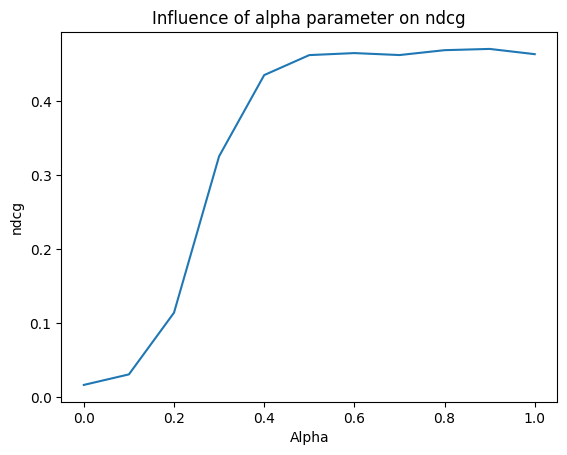

In [ ]:
import matplotlib.pyplot as plt
alpha = np.arange(0,1.1,0.1)
plt.plot(alpha,bert_res)
plt.xlabel('Alpha')
plt.ylabel('ndcg')
plt.title('Influence of alpha parameter on ndcg')
plt.show()

In [ ]:
Scoring(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName)

ndcg bm25= 0.7411284941319424


0.7411284941319424

In [ ]:
Scoring_OG(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName)

ndcg bm25= 0.46335714418774215


0.46335714418774215

In [ ]:
Scoring_Token(corpusDocTokenList,corpusDicoDocName,corpusReqTokenList,corpusReqName,corpusDicoReqName)

ndcg bm25= 0.2729997913956099


0.2729997913956099